In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

from utils import preprocess, transform_features, handle_missing_values, standardize
from sklearn.svm import OneClassSVM

In [2]:
# XMatch case
#df_all = pd.read_csv('data/CSC2.0-GAIA_DR2_Xmatch.txt', delimiter='\t', comment='#', header=None)

# df_all.columns = [
#     'csc2_ensemble_no', 'csc2_name', 'csc2_type', 'csc2_ra', 'csc2_dec',
#     'csc2_semi_major_axis', 'csc2_semi_minor_axis', 'csc2_position_angle',
#     'csc2_semi_major_axis_psf', 'csc2_semi_minor_axis_psf', 'csc2_position_angle_psf',
#     'gaia_dr2_name', 'gaia_dr2_type', 'gaia_dr2_ra', 'gaia_dr2_dec',
#     'gaia_dr2_semi_major_axis', 'gaia_dr2_semi_minor_axis', 'gaia_dr2_position_angle',
#     'gaia_dr2_semi_major_axis_psf', 'gaia_dr2_semi_minor_axis_psf', 'gaia_dr2_position_angle_psf',
#     'match_class', 'bf_type', 'match_probability', 'separation', 'separation_sigma'
# ]

df_csc_gaia_15_all = pd.read_csv('data/allcsc_gaia_15.csv') # Crossmatch with Gaia in 15 arcsec
df_csc_all = pd.read_csv('data/allcsc_gaia_15.csv') # All CSC
df_xmatch_all = pd.read_csv('data/gaia_chandra_with_features-result.csv') #XMatch
#df_bad = df_all.query("match_probability < 0.7 and separation > 2 and parallax == parallax and parallax >= 0")

/tmp/ipykernel_1007001/4268460441.py:14: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csc_gaia_15_all = pd.read_csv('data/allcsc_gaia_15.csv')
/tmp/ipykernel_1007001/4268460441.py:15: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csc_all = pd.read_csv('data/allcsc_gaia_15.csv')


In [3]:
df_good = df_xmatch_all.query("match_probability >= 0.95 and separation < 0.2 and parallax == parallax and parallax >= 0")
df_good = df_good.merge(df_csc_all, left_on='csc2_name', right_on='name', how='left')

# Get counts of each 'Source'
source_counts = df_csc_all['Source'].value_counts()

# Identify 'Source' values that appear only once
unique_sources = source_counts[source_counts == 1].index

df_bad = df_csc_all[df_csc_all['Source'].isin(unique_sources)]

# Select entries with angDist >= 5
df_bad = df_bad.query('angDist >= 12')

# Remove entries found in df_xmatch_all
df_bad = df_bad[~df_bad['Source'].isin(df_xmatch_all['source_id'])]

# Sample to match the size of df_good
df_bad = df_bad.sample(df_good.shape[0])

df_bad['G_flux'] = df_bad['FG']
df_good['G_flux'] = df_good['phot_g_mean_flux']

In [159]:
yangxgood = pd.merge(df_good, yangetal, on='name')

In [160]:
# Group by 'Class' and count for probs > 0.5
yangxgood_props = yangxgood['Class'].value_counts().reset_index()
yangxgood_props.columns = ['Class', 'Count_gt_05']
yangxgood_props['Percentage_gt_05'] = (yangxgood_props['Count_gt_05'] / yangxgood_props['Count_gt_05'].sum()) * 100

In [161]:
yangxgood_props

,Class,Count_gt_05,Percentage_gt_05
0,YSO,144,33.256351
1,AGN,128,29.561201
2,LM-STAR,121,27.944573
3,HM-STAR,24,5.542725
4,CV,10,2.309469
5,HMXB,4,0.923788
6,LMXB,2,0.461894


In [4]:
df_bad['phot_g_mean_mag'] = df_bad['Gmag']
df_bad['phot_bp_mean_mag'] = df_bad['BPmag']
df_bad['phot_rp_mean_mag'] = df_bad['RPmag']
df_bad['bp_rp'] = df_bad['BP-RP']
df_bad['bp_g'] = df_bad['BP-G']
df_bad['g_rp'] = df_bad['G-RP']
df_bad['parallax'] = df_bad['Plx']
df_bad['parallax_over_error'] = df_bad['RPlx']
df_bad['sep_test'] = df_bad['angDist']
df_bad['gmag_logflux'] = df_bad['phot_g_mean_mag'] + np.log10( 1 + df_bad['flux_aper_b'])

df_good['sep_test'] = df_good['separation']
df_good['gmag_logflux'] = df_good['phot_g_mean_mag'] + np.log10( 1 + df_good['flux_aper_b'])

In [5]:
df_all = pd.concat([df_good, df_bad], ignore_index=True)

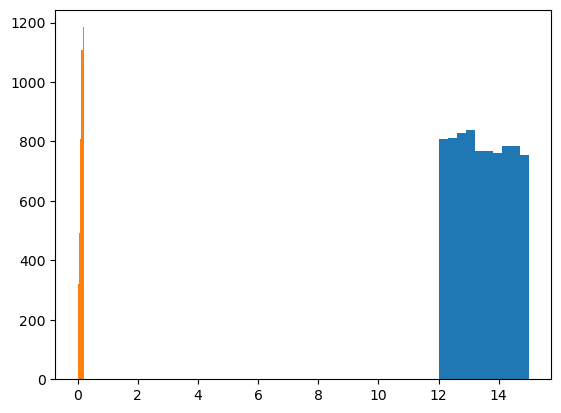

In [6]:
plt.hist(df_bad.sep_test);
plt.hist(df_good.sep_test);

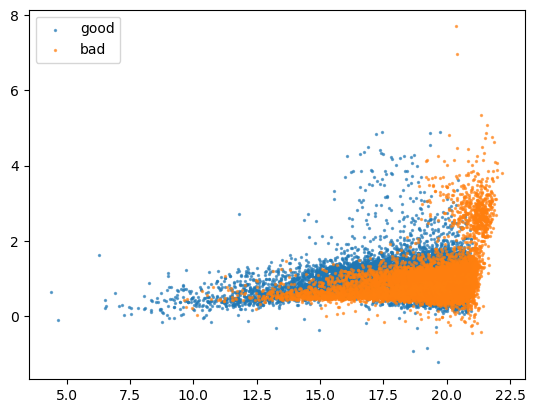

In [7]:
plt.scatter(df_good['gmag_logflux'],df_good['g_rp'],alpha=0.6, label='good', s=2)
plt.scatter(df_bad['gmag_logflux'],df_bad['g_rp'],alpha=0.6, label='bad', s=2)
plt.legend()

In [ ]:
sns.kdeplot(x=df_good.var_intra_prob_b, y=df_good.G_flux, label = 'High prob matches',fill=True,alpha=0.8, log_scale=[False, True])
sns.kdeplot(x=df_bad.var_intra_prob_b, y=df_bad.G_flux, label = 'Low prob matches',fill=False,alpha=0.9, color='red', log_scale=[False, True])

In [8]:
feature_names = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'flux_aper_b',
    'gmag_logflux'
]

# List of features to skip for the log transformation
skip_log_features = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'gmag_logflux'
]

In [9]:
# Preprocess the data
X, Y = preprocess(df_good, df_bad, feature_names, skip_log_features)
indices = np.arange(X.shape[0])

# Split into training and test sets
(X_train, 
 X_test, 
 Y_train, 
 Y_test, 
 indices_train, 
 indices_test) = train_test_split(X, Y, indices, test_size=0.3, shuffle=True)

# Handle missing values
X_train, X_test, imp_mean = handle_missing_values(X_train, X_test)

# Standardize
#X_train, X_test, scaler = standardize(X_train, X_test)

/mnt/d/workspace/starsml/utils.py:7: RuntimeWarning: invalid value encountered in log10
  np.log10(1 + df[feature].values) if feature not in skip_log_features else df[feature].values


In [11]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=20)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print(f"RF train accuracy: {clf_rf.score(X_train, Y_train):.3f}")
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

# Check Scalar and Missing Values
# Error Analysis (check distances of matches in errors)

RF train accuracy: 0.911
Accuracy: 0.8872497365648051
Precision: 0.8920168067226891
Recall: 0.8842149104539775
F1 Score: 0.8880987241162936
AUC-ROC: 0.9564251172364189


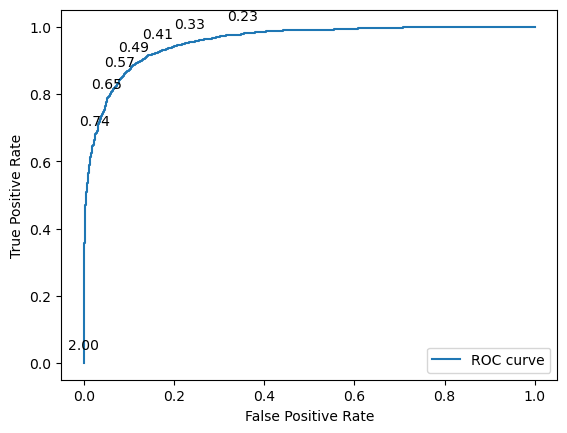

In [12]:
# Assuming Y_test and y_pred_rf_prob are defined
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_rf_prob, pos_label=1)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Annotate some points on the curve. You might want to annotate just a subset
# for clarity, depending on how many points you have.
for i, threshold in enumerate(thresholds):
    if i % 100 == 0:  # annotate every 10th point
        plt.annotate(f"{threshold:.2f}", (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(loc='best')
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 1, 2, 3], 
    'max_features': [2, 3, 4, 5]
}

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, 
                           cv=10, n_jobs=-1, verbose=1, scoring='f1')

grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Fitting 10 folds for each of 48 candidates, totalling 480 fits


Best parameters: {'max_depth': None, 'max_features': 5, 'n_estimators': 100}


In [26]:
from sklearn.model_selection import cross_validate
best_params = {'max_depth': 8, 'max_features': 5, 'n_estimators': 100}

clf_rf_best = RandomForestClassifier(**best_params, random_state=42)
#clf_rf = RandomForestClassifier(**best_params)

cv_scores = cross_validate(clf_rf_best, X_train, Y_train, cv=3, scoring=['f1', 'accuracy', 'recall', 'precision'],  return_train_score=True)

clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC


In [27]:
print(f"RF train accuracy: {cv_scores['train_accuracy'].mean():.3f}")
print("Accuracy:", cv_scores['test_accuracy'].mean())
print("Precision:", cv_scores['test_precision'].mean())
print("Recall:", cv_scores['test_recall'].mean())
print("F1 Score:", cv_scores['test_f1'].mean())

RF train accuracy: 0.924
Accuracy: 0.8787606554117406
Precision: 0.8864837923573035
Recall: 0.8674160349375395
F1 Score: 0.8768033570279533


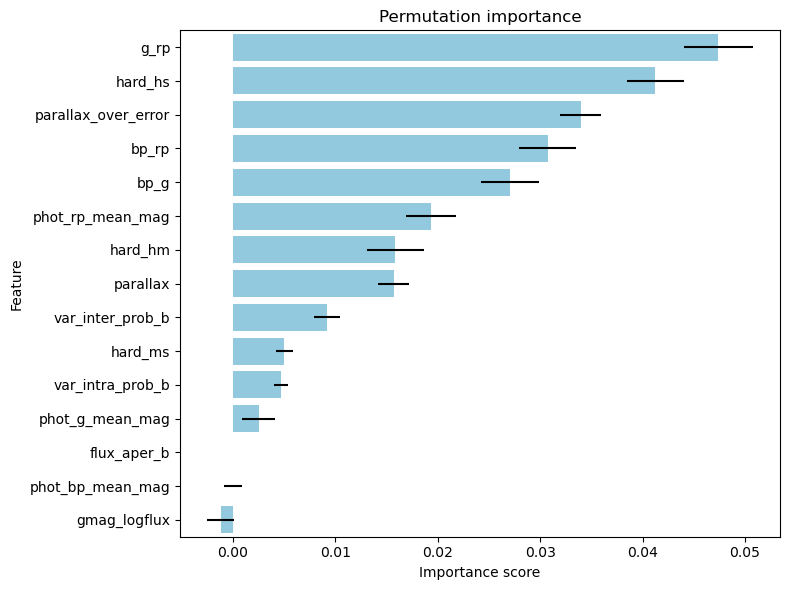

In [29]:
# Calculate permutation importances
per_importances = permutation_importance(
    clf_rf, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)

# Sort the features by importance in descending order
sorted_idx = per_importances.importances_mean.argsort()[::-1]

# Create a Pandas DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_idx],
    'Importance': per_importances.importances_mean[sorted_idx],
    'Importance_std': per_importances.importances_std[sorted_idx]
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue', errorbar=None, capsize=.1, xerr=importance_df['Importance_std'])

# Add labels and title
plt.title("Permutation importance")
plt.xlabel("Importance score")
plt.tight_layout()

In [139]:
# Sample dataframes (replace these with your real df_train, df_test, df_totest)
df_train = df_all.iloc[indices_train]
df_train['prediction'] = clf_rf.predict(X_train)
df_train['actual'] = Y_train
y_train_rf_prob = clf_rf.predict_proba(X_train)[:, 1]

df_test = df_all.iloc[indices_test]
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

df_to_test = df_xmatch_all[~df_xmatch_all['source_id'].isin(df_bad['Source'])]
df_to_test = df_to_test[~df_to_test['source_id'].isin(df_good['Source'])]
df_to_test = df_to_test.merge(df_csc_all, left_on='csc2_name', right_on='name', how='left')
df_to_test['gmag_logflux'] = df_to_test['phot_g_mean_mag'] + np.log10( 1 + df_to_test['flux_aper_b'])
df_to_test['sep_test'] = df_to_test['separation']
new_df_bad_to_test = transform_features(df_to_test, feature_names, skip_log_features)
new_df_bad_to_test = imp_mean.transform(new_df_bad_to_test)
#new_df_bad_to_test = scaler.transform(new_df_bad_to_test)
df_to_test['prediction'] = clf_rf.predict(new_df_bad_to_test) # for AUC
y_to_test_rf_prob = clf_rf.predict_proba(new_df_bad_to_test)[:, 1]
df_to_test['actual'] = df_to_test.match_probability > 0.7

# List of dataframes and their names
dfs = [df_train, df_test, df_to_test]
names = ['Train', 'Test', 'Benchmark']

features = feature_names

/tmp/ipykernel_1007001/491610289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['prediction'] = clf_rf.predict(X_train)
/tmp/ipykernel_1007001/491610289.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['actual'] = Y_train
/tmp/ipykernel_1007001/491610289.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

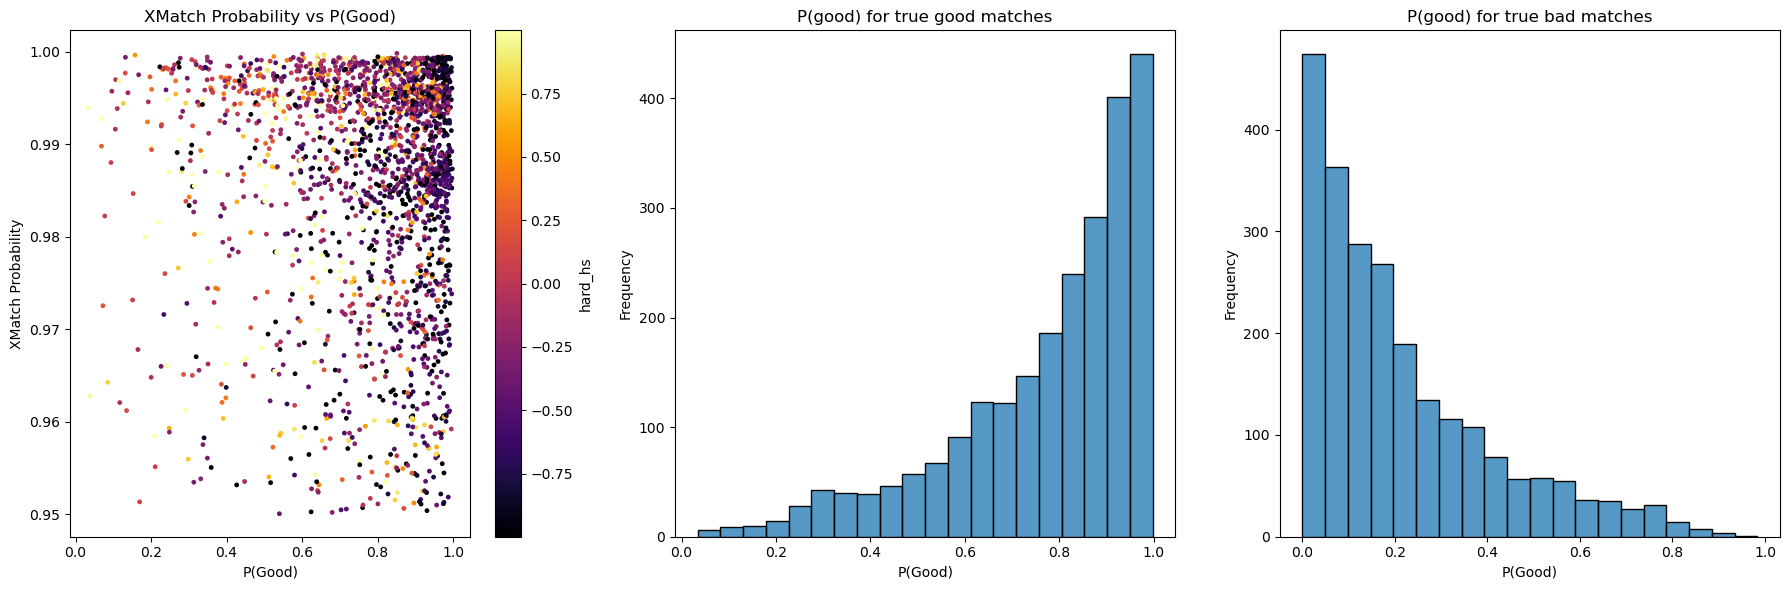

In [120]:
# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot: XMatch Probability vs Our Probabilities
cd = ax[0].scatter(data=df_test[df_test.actual == 1], y='match_probability', x=y_pred_rf_prob[Y_test == 1], s=6, c=df_test[df_test.actual == 1].hard_hs, cmap="inferno")
ax[0].set_title('XMatch Probability vs P(Good)')
ax[0].set_ylabel('XMatch Probability')
ax[0].set_xlabel('P(Good)')
plt.colorbar(cd, label='hard_hs')

# Histogram: Our Probabilities (Predicted Good)
sns.histplot(y_pred_rf_prob[df_test.actual == 1], bins=20, kde=False, ax=ax[1])
ax[1].set_title('P(good) for true good matches')
ax[1].set_xlabel('P(Good)')
ax[1].set_ylabel('Frequency')

# Histogram: Our Probabilities (Predicted Bad)
sns.histplot(y_pred_rf_prob[df_test.actual == 0], bins=20, kde=False, ax=ax[2])
ax[2].set_title('P(good) for true bad matches')
ax[2].set_xlabel('P(Good)')
ax[2].set_ylabel('Frequency')

# Make sure bins are comparable for histogram plots
# Show the plots
plt.tight_layout()
plt.savefig('figures/test_set_probabilites.pdf')

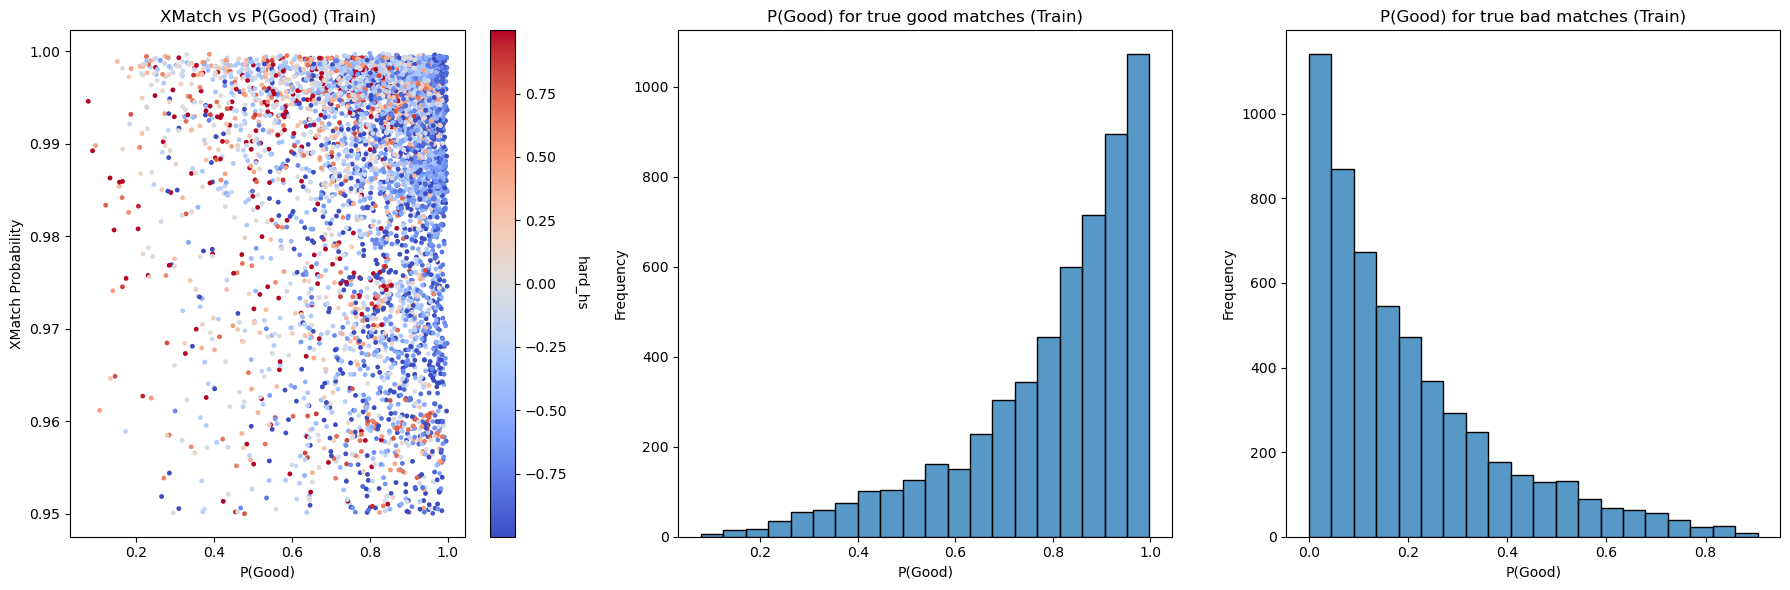

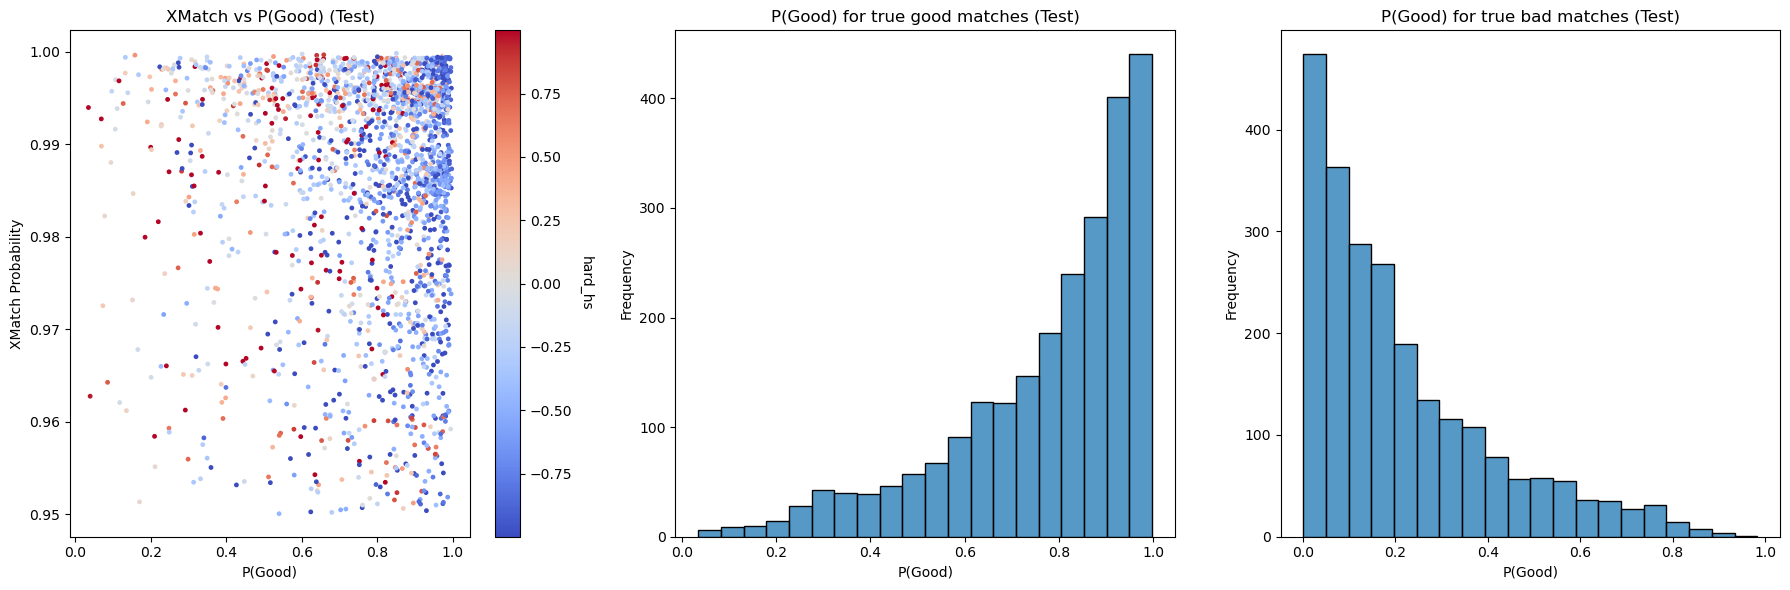

In [140]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('figures/histograms_probs.pdf') as pdf:
    # Plot for each dataset
    for dataset, pred_prob, title in zip([df_train, df_test, df_to_test], 
                                        [y_train_rf_prob, y_pred_rf_prob, y_to_test_rf_prob], 
                                        ['Train', 'Test', 'Benchmark']):
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        
        # Scatter Plot
        cmap = 'coolwarm'
        norm = plt.Normalize(dataset['hard_hs'].min(), dataset['hard_hs'].max())
        sc = ax[0].scatter(pred_prob, dataset['match_probability'], 
                        c=dataset['hard_hs'], cmap=cmap, norm=norm, s=6)
        cbar = plt.colorbar(sc, ax=ax[0])
        cbar.set_label('hard_hs', rotation=270, labelpad=15)
        ax[0].set_title(f'XMatch vs P(Good) ({title})')
        ax[0].set_ylabel('XMatch Probability')
        ax[0].set_xlabel('P(Good)')
        
        # Histogram: Our Probabilities (Predicted Good)
        sns.histplot(pred_prob[dataset.actual == 1], bins=20, kde=False, ax=ax[1])
        ax[1].set_title(f'P(Good) for true good matches ({title})')
        ax[1].set_xlabel('P(Good)')
        ax[1].set_ylabel('Frequency')
        
        # Histogram: Our Probabilities (Predicted Bad)
        sns.histplot(pred_prob[dataset.actual == 0], bins=20, kde=False, ax=ax[2])
        ax[2].set_title(f'P(Good) for true bad matches ({title})')
        ax[2].set_xlabel('P(Good)')
        ax[2].set_ylabel('Frequency')
        
        plt.tight_layout()
        pdf.savefig(fig); 
plt.close();

In [132]:
with PdfPages('figures/distributions_predicted_datasets.pdf') as pdf:
    for feature in features:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for Train, Test, ToTest
    
        for ax, df, name in zip(axs, dfs, names):
            ax.hist(df[df['prediction'] == 1][feature], bins=20, alpha=0.5, label='Good')
            ax.hist(df[df['prediction'] == 0][feature], bins=20, alpha=0.5, label='Bad')
            ax.set_title(f'{name} - {feature}')
            ax.legend()

        pdf.savefig(fig);  # Saves the current figure into a pdf page
        plt.close();  # Close the figure to free up memory

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u

with PdfPages('figures/sky_predicted_datasets.pdf') as pdf:
    # Inside your loop where you plot for each dataframe
    for df, name in zip([df_train, df_test, df_to_test], ['Train', 'Test', 'Benchmark']):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='mollweide')
        ax.set_rasterization_zorder(1)

        # Transform coordinates to Galactic
        if name == 'Benchmark':
            skycoord = SkyCoord(ra=df['csc2_ra']*u.degree, dec=df['csc2_dec']*u.degree, frame='icrs')
        else:
            skycoord = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')
        galactic = skycoord.galactic
        l_rad = galactic.l.wrap_at(180*u.degree).radian
        b_rad = galactic.b.radian

        df['l_rad'] = l_rad
        df['b_rad'] = b_rad
        
        # Filter by classification
        l_good = df[df['prediction'] == 1]['l_rad']
        b_good = df[df['prediction'] == 1]['b_rad']
        
        l_bad = df[df['prediction'] == 0]['l_rad']
        b_bad = df[df['prediction'] == 0]['b_rad']
        
        # Initialize figure
        fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': 'mollweide'})

        # KDE plot for good samples
        sns.kdeplot(x=l_good, y=b_good, cmap='BuPu', fill=True, ax=axes[0], common_norm=False, rasterized=True)

        # KDE plot for bad samples
        sns.kdeplot(x=l_bad, y=b_bad, cmap='BuPu', fill=True, ax=axes[1], common_norm=False, rasterized=True)

        # Set titles and save the figure
        axes[0].set_title('Good')
        axes[1].set_title('Bad')

        # Super title for the page
        plt.suptitle(f"Sky Distribution KDE in Galactic Coordinates ({name})")

        # Save this figure into the PDF
        pdf.savefig(fig, dpi=150);

        # Close the figure to free up memory
        plt.close(fig);

In [ ]:
# Create a PDF
from matplotlib.backends.backend_pdf import PdfPages
pdf_pages = PdfPages('figures/probs_benchmark_separation_slices.pdf')

# Define separation thresholds for good sources
separation_thresholds = [1, 1.5, 2, 2.5, 3, 5]  # Replace these with your desired separation values

# Loop through separation thresholds
for threshold in separation_thresholds:

    df_to_test['actual'] = df_to_test.separation < threshold  # Setting actual labels based on threshold

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Histogram: Our Probabilities (Predicted Good)
    sns.histplot(y_to_test_rf_prob[df_to_test.actual == 1], bins=20, kde=False, ax=ax[0])
    ax[0].set_title(f'P(good) for true good matches (Sep. Thresh.: {threshold})')
    ax[0].set_xlabel('P(Good)')
    ax[0].set_ylabel('Frequency')

    # Histogram: Our Probabilities (Predicted Bad)
    sns.histplot(y_to_test_rf_prob[df_to_test.actual == 0], bins=20, kde=False, ax=ax[1])
    ax[1].set_title(f'P(good) for true bad matches (Sep. Thresh.: {threshold})')
    ax[1].set_xlabel('P(Good)')
    ax[1].set_ylabel('Frequency')

    plt.tight_layout()
    pdf_pages.savefig(fig)

pdf_pages.close()


In [ ]:
# Concatenate good and bad datasets to refer back later
df_test = df_all.iloc[indices_test]

# Add predictions and actual labels
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

#df_test = df_test.query('separation <=0.2 and parallax >=0')
# Define categories based on predictions and actual labels
# df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
#                                                   'true bad' if row['prediction'] == row['actual'] == 0 else 
#                                                   'false good' if row['prediction'] == 1 else 'false bad', axis=1)

df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
                                                  'false bad' if row['prediction'] == 0 and row['actual'] == 1 else None, axis=1)

# df_test['category'] = df_test.apply(lambda row: 'true bad' if row['prediction'] == row['actual'] == 0 else 
#                                                   'false bad' if row['prediction'] == 0 and row['actual'] == 1 else None, axis=1)

# Plot
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")


sns.kdeplot(data = df_test, x='hard_hs', y='bp_rp', 
            hue='category')

plt.show()


In [19]:
#df_to_test = df_csc_all[~df_csc_all['Source'].isin(df_xmatch_all['source_id'])]
df_to_test = df_xmatch_all[~df_xmatch_all['source_id'].isin(df_bad['Source'])]
df_to_test = df_to_test[~df_to_test['source_id'].isin(df_good['Source'])]
df_to_test = df_to_test.merge(df_csc_all, left_on='csc2_name', right_on='name', how='left')
#df_to_test = df_to_test.query('angDist > 5')
#df_to_test['G_flux'] = df_to_test['FG']
df_to_test['gmag_logflux'] = df_to_test['phot_g_mean_mag'] + np.log10( 1 + df_to_test['flux_aper_b'])
df_to_test['sep_test'] = df_to_test['separation']

#df_to_test = df_to_test.query('separation < 0.5')


new_df_bad_to_test = transform_features(df_to_test, feature_names, skip_log_features)
new_df_bad_to_test = imp_mean.transform(new_df_bad_to_test)
#new_df_bad_to_test = scaler.transform(new_df_bad_to_test)
y_pred_totest = clf_rf.predict_proba(new_df_bad_to_test)[:, 1]  # for AUC

/mnt/d/workspace/starsml/utils.py:7: RuntimeWarning: invalid value encountered in log10
  np.log10(1 + df[feature].values) if feature not in skip_log_features else df[feature].values


Text(0, 0.5, 'XMatch probability')

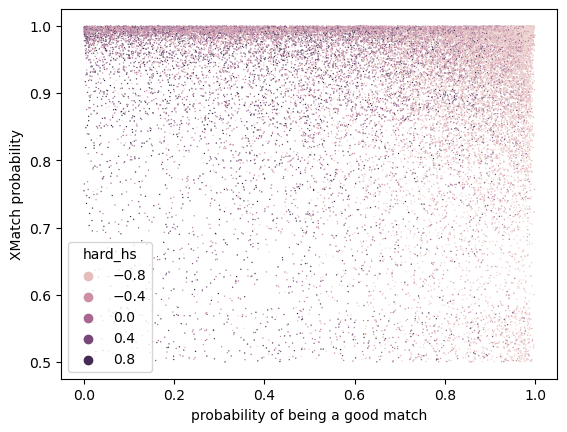

In [20]:
sns.scatterplot(x=y_pred_totest, y=df_to_test['match_probability'], hue=df_to_test['hard_hs'], s=1);
plt.xlabel('probability of being a good match')
plt.ylabel('XMatch probability')

In [146]:
yangetal = pd.read_csv('data/CXO Training Dataset.csv', index_col=False)
df_to_test['probs_pred'] = y_pred_totest
yangxtest = pd.merge(df_to_test, yangetal, on='name')

In [152]:
yangxtest.shape

(1322, 218)

In [147]:
# Group the data by 'Class' and calculate the mean probability and count for each group
grouped_df = yangxtest.groupby('Class').agg({
    'probs_pred': ['mean'],
    'Class': ['count']
}).reset_index()

# Calculate the total number of rows for percentage calculation
total_rows = len(yangxtest)

# Add a new column to store the percentage of each class
grouped_df['percentage'] = (grouped_df[('Class', 'count')] / total_rows) * 100

# Rename columns for easier interpretation
grouped_df.columns = ['Class', 'Mean Probability', 'Count', 'Percentage']

print(grouped_df)


     Class  Mean Probability  Count  Percentage
0      AGN          0.421629    605   45.763994
1       CV          0.558383     20    1.512859
2  HM-STAR          0.864069     61    4.614221
3     HMXB          0.447407     11    0.832073
4  LM-STAR          0.915204    388   29.349470
5     LMXB          0.480491     17    1.285930
6       NS          0.861158      1    0.075643
7      YSO          0.776809    219   16.565809


In [148]:
# Filter DataFrame based on 'probs_pred' > 0.5
filtered_gt_05 = yangxtest[yangxtest['probs_pred'] > 0.5]

# Filter DataFrame based on 'probs_pred' <= 0.5
filtered_le_05 = yangxtest[yangxtest['probs_pred'] <= 0.5]

# Group by 'Class' and count for probs > 0.5
grouped_gt_05 = filtered_gt_05['Class'].value_counts().reset_index()
grouped_gt_05.columns = ['Class', 'Count_gt_05']
grouped_gt_05['Percentage_gt_05'] = (grouped_gt_05['Count_gt_05'] / grouped_gt_05['Count_gt_05'].sum()) * 100

# Group by 'Class' and count for probs <= 0.5
grouped_le_05 = filtered_le_05['Class'].value_counts().reset_index()
grouped_le_05.columns = ['Class', 'Count_le_05']
grouped_le_05['Percentage_le_05'] = (grouped_le_05['Count_le_05'] / grouped_le_05['Count_le_05'].sum()) * 100


In [149]:
grouped_gt_05

,Class,Count_gt_05,Percentage_gt_05
0,LM-STAR,383,44.483159
1,AGN,200,23.228804
2,YSO,195,22.648084
3,HM-STAR,57,6.620209
4,CV,12,1.393728
5,LMXB,9,1.045296
6,HMXB,4,0.464576
7,NS,1,0.116144


In [150]:
grouped_le_05

,Class,Count_le_05,Percentage_le_05
0,AGN,405,87.852495
1,YSO,24,5.206074
2,CV,8,1.735358
3,LMXB,8,1.735358
4,HMXB,7,1.518438
5,LM-STAR,5,1.084599
6,HM-STAR,4,0.867679


<Axes: ylabel='match_probability'>

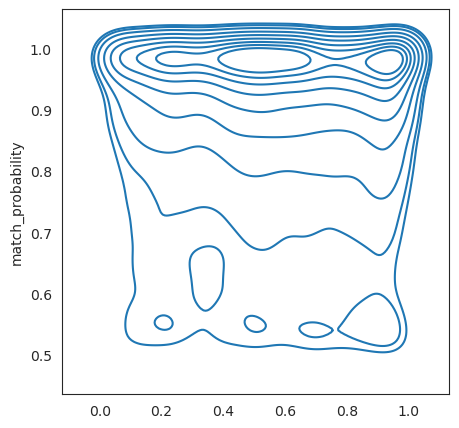

In [69]:
sns.kdeplot(x=y_pred_totest, y=df_to_test['match_probability'])


Text(0, 0.5, 'separation')

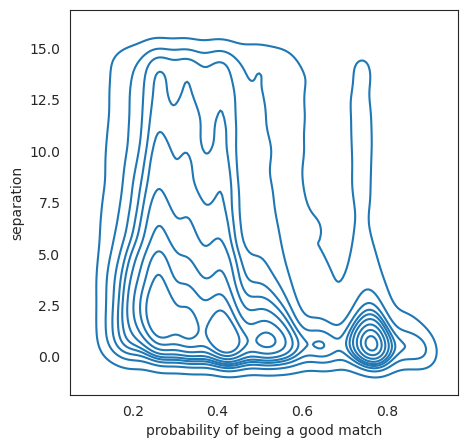

In [66]:
sns.kdeplot(x=y_pred_totest, y=df_to_test['angDist'])
plt.xlabel('probability of being a good match')
plt.ylabel('separation')

Text(0, 0.5, 'separation')

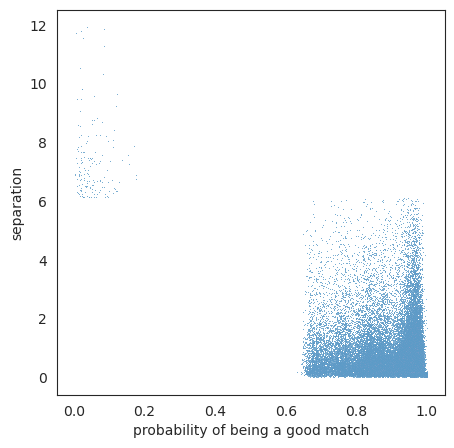

In [171]:
sns.scatterplot(x=y_pred_totest, y=df_to_test['separation'], s=0.5);
plt.xlabel('probability of being a good match')
plt.ylabel('separation')